In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(684288, 828)
(684288, 1)
validation
(113488, 828)
(113488, 1)
test
(56512, 828)
(56512, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/69 [..............................] - ETA: 1:28 - loss: 0.0524 - STD: 2.2414e-04 - MAE: 0.2187

 4/69 [>.............................] - ETA: 2s - loss: 0.0327 - STD: 2.9276e-04 - MAE: 0.1390  

 5/69 [=>............................] - ETA: 3s - loss: 0.0326 - STD: 2.6494e-04 - MAE: 0.1388

 6/69 [=>............................] - ETA: 4s - loss: 0.0319 - STD: 2.4496e-04 - MAE: 0.1361

 7/69 [==>...........................] - ETA: 4s - loss: 0.0304 - STD: 2.3858e-04 - MAE: 0.1300

 8/69 [==>...........................] - ETA: 4s - loss: 0.0286 - STD: 2.4498e-04 - MAE: 0.1224

 9/69 [==>...........................] - ETA: 4s - loss: 0.0269 - STD: 2.6100e-04 - MAE: 0.1177

10/69 [===>..........................] - ETA: 5s - loss: 0.0259 - STD: 2.8230e-04 - MAE: 0.1167

11/69 [===>..........................] - ETA: 5s - loss: 0.0254 - STD: 3.0429e-04 - MAE: 0.1175

12/69 [====>.........................] - ETA: 5s - loss: 0.0250 - STD: 3.2669e-04 - MAE: 0.1185

13/69 [====>.........................] - ETA: 5s - loss: 0.0245 - STD: 3.4687e-04 - MAE: 0.1186

14/69 [=====>........................] - ETA: 5s - loss: 0.0239 - STD: 3.6536e-04 - MAE: 0.1173

15/69 [=====>........................] - ETA: 5s - loss: 0.0232 - STD: 3.8035e-04 - MAE: 0.1149

16/69 [=====>........................] - ETA: 4s - loss: 0.0226 - STD: 3.9273e-04 - MAE: 0.1121

17/69 [======>.......................] - ETA: 4s - loss: 0.0222 - STD: 4.0333e-04 - MAE: 0.1095

18/69 [======>.......................] - ETA: 4s - loss: 0.0218 - STD: 4.1266e-04 - MAE: 0.1073

19/69 [=======>......................] - ETA: 4s - loss: 0.0216 - STD: 4.2167e-04 - MAE: 0.1054

20/69 [=======>......................] - ETA: 4s - loss: 0.0213 - STD: 4.3079e-04 - MAE: 0.1037

21/69 [========>.....................] - ETA: 4s - loss: 0.0210 - STD: 4.4099e-04 - MAE: 0.1021

22/69 [========>.....................] - ETA: 4s - loss: 0.0208 - STD: 4.5242e-04 - MAE: 0.1006

23/69 [=========>....................] - ETA: 4s - loss: 0.0205 - STD: 4.6500e-04 - MAE: 0.0991

24/69 [=========>....................] - ETA: 4s - loss: 0.0201 - STD: 4.7948e-04 - MAE: 0.0980

25/69 [=========>....................] - ETA: 4s - loss: 0.0199 - STD: 4.9526e-04 - MAE: 0.0973

26/69 [==========>...................] - ETA: 4s - loss: 0.0197 - STD: 5.1187e-04 - MAE: 0.0969

27/69 [==========>...................] - ETA: 4s - loss: 0.0195 - STD: 5.2959e-04 - MAE: 0.0968

28/69 [===========>..................] - ETA: 4s - loss: 0.0193 - STD: 5.4700e-04 - MAE: 0.0967

29/69 [===========>..................] - ETA: 4s - loss: 0.0192 - STD: 5.6468e-04 - MAE: 0.0966

30/69 [============>.................] - ETA: 3s - loss: 0.0190 - STD: 5.8168e-04 - MAE: 0.0963

31/69 [============>.................] - ETA: 3s - loss: 0.0188 - STD: 5.9890e-04 - MAE: 0.0958

32/69 [============>.................] - ETA: 3s - loss: 0.0187 - STD: 6.1514e-04 - MAE: 0.0952

33/69 [=============>................] - ETA: 3s - loss: 0.0185 - STD: 6.3078e-04 - MAE: 0.0944

34/69 [=============>................] - ETA: 3s - loss: 0.0184 - STD: 6.4604e-04 - MAE: 0.0937

35/69 [==============>...............] - ETA: 3s - loss: 0.0182 - STD: 6.6156e-04 - MAE: 0.0929

36/69 [==============>...............] - ETA: 3s - loss: 0.0181 - STD: 6.7760e-04 - MAE: 0.0922

37/69 [===============>..............] - ETA: 3s - loss: 0.0180 - STD: 6.9485e-04 - MAE: 0.0916

38/69 [===============>..............] - ETA: 3s - loss: 0.0179 - STD: 7.1300e-04 - MAE: 0.0909

39/69 [===============>..............] - ETA: 3s - loss: 0.0178 - STD: 7.3265e-04 - MAE: 0.0905

40/69 [================>.............] - ETA: 2s - loss: 0.0177 - STD: 7.5420e-04 - MAE: 0.0900

41/69 [================>.............] - ETA: 2s - loss: 0.0176 - STD: 7.7669e-04 - MAE: 0.0897

42/69 [=================>............] - ETA: 2s - loss: 0.0175 - STD: 8.0136e-04 - MAE: 0.0895

43/69 [=================>............] - ETA: 2s - loss: 0.0174 - STD: 8.2710e-04 - MAE: 0.0893

44/69 [==================>...........] - ETA: 2s - loss: 0.0173 - STD: 8.5420e-04 - MAE: 0.0891

45/69 [==================>...........] - ETA: 2s - loss: 0.0172 - STD: 8.8222e-04 - MAE: 0.0889

46/69 [===================>..........] - ETA: 2s - loss: 0.0171 - STD: 9.1088e-04 - MAE: 0.0887

47/69 [===================>..........] - ETA: 2s - loss: 0.0170 - STD: 9.4079e-04 - MAE: 0.0884

48/69 [===================>..........] - ETA: 2s - loss: 0.0170 - STD: 9.7119e-04 - MAE: 0.0881

49/69 [====================>.........] - ETA: 2s - loss: 0.0169 - STD: 0.0010 - MAE: 0.0878    

50/69 [====================>.........] - ETA: 1s - loss: 0.0168 - STD: 0.0010 - MAE: 0.0874

51/69 [=====================>........] - ETA: 1s - loss: 0.0167 - STD: 0.0011 - MAE: 0.0871

52/69 [=====================>........] - ETA: 1s - loss: 0.0167 - STD: 0.0011 - MAE: 0.0868

53/69 [======================>.......] - ETA: 1s - loss: 0.0166 - STD: 0.0011 - MAE: 0.0865

54/69 [======================>.......] - ETA: 1s - loss: 0.0166 - STD: 0.0012 - MAE: 0.0862

55/69 [======================>.......] - ETA: 1s - loss: 0.0165 - STD: 0.0012 - MAE: 0.0860

56/69 [=======================>......] - ETA: 1s - loss: 0.0164 - STD: 0.0013 - MAE: 0.0858

57/69 [=======================>......] - ETA: 1s - loss: 0.0164 - STD: 0.0013 - MAE: 0.0856

58/69 [========================>.....] - ETA: 1s - loss: 0.0163 - STD: 0.0014 - MAE: 0.0855

59/69 [========================>.....] - ETA: 1s - loss: 0.0163 - STD: 0.0015 - MAE: 0.0854

60/69 [=========================>....] - ETA: 0s - loss: 0.0162 - STD: 0.0015 - MAE: 0.0852

61/69 [=========================>....] - ETA: 0s - loss: 0.0162 - STD: 0.0016 - MAE: 0.0851

62/69 [=========================>....] - ETA: 0s - loss: 0.0161 - STD: 0.0017 - MAE: 0.0849

63/69 [==========================>...] - ETA: 0s - loss: 0.0161 - STD: 0.0017 - MAE: 0.0847

64/69 [==========================>...] - ETA: 0s - loss: 0.0160 - STD: 0.0018 - MAE: 0.0844

65/69 [===========================>..] - ETA: 0s - loss: 0.0160 - STD: 0.0019 - MAE: 0.0842

66/69 [===========================>..] - ETA: 0s - loss: 0.0159 - STD: 0.0020 - MAE: 0.0840

67/69 [============================>.] - ETA: 0s - loss: 0.0159 - STD: 0.0021 - MAE: 0.0838

69/69 [==============================] - 9s 120ms/step - loss: 0.0158 - STD: 0.0023 - MAE: 0.0834 - val_loss: 0.0130 - val_STD: 0.0084 - val_MAE: 0.0725


Epoch 2/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0119 - STD: 0.0114 - MAE: 0.0709

 2/69 [..............................] - ETA: 7s - loss: 0.0122 - STD: 0.0120 - MAE: 0.0720

 3/69 [>.............................] - ETA: 7s - loss: 0.0121 - STD: 0.0126 - MAE: 0.0720

 4/69 [>.............................] - ETA: 6s - loss: 0.0120 - STD: 0.0131 - MAE: 0.0717

 5/69 [=>............................] - ETA: 6s - loss: 0.0120 - STD: 0.0137 - MAE: 0.0714

 6/69 [=>............................] - ETA: 6s - loss: 0.0120 - STD: 0.0144 - MAE: 0.0712

 7/69 [==>...........................] - ETA: 6s - loss: 0.0119 - STD: 0.0151 - MAE: 0.0706

 8/69 [==>...........................] - ETA: 6s - loss: 0.0117 - STD: 0.0158 - MAE: 0.0699

10/69 [===>..........................] - ETA: 5s - loss: 0.0116 - STD: 0.0174 - MAE: 0.0693

11/69 [===>..........................] - ETA: 5s - loss: 0.0115 - STD: 0.0184 - MAE: 0.0689

12/69 [====>.........................] - ETA: 5s - loss: 0.0114 - STD: 0.0194 - MAE: 0.0685

13/69 [====>.........................] - ETA: 5s - loss: 0.0113 - STD: 0.0205 - MAE: 0.0682

14/69 [=====>........................] - ETA: 5s - loss: 0.0112 - STD: 0.0216 - MAE: 0.0679

15/69 [=====>........................] - ETA: 5s - loss: 0.0111 - STD: 0.0228 - MAE: 0.0675

16/69 [=====>........................] - ETA: 5s - loss: 0.0109 - STD: 0.0240 - MAE: 0.0671

17/69 [======>.......................] - ETA: 5s - loss: 0.0108 - STD: 0.0253 - MAE: 0.0666

18/69 [======>.......................] - ETA: 5s - loss: 0.0106 - STD: 0.0266 - MAE: 0.0661

19/69 [=======>......................] - ETA: 5s - loss: 0.0105 - STD: 0.0280 - MAE: 0.0657

20/69 [=======>......................] - ETA: 5s - loss: 0.0103 - STD: 0.0294 - MAE: 0.0652

21/69 [========>.....................] - ETA: 5s - loss: 0.0102 - STD: 0.0310 - MAE: 0.0648

22/69 [========>.....................] - ETA: 4s - loss: 0.0101 - STD: 0.0325 - MAE: 0.0644

23/69 [=========>....................] - ETA: 4s - loss: 0.0099 - STD: 0.0339 - MAE: 0.0640

24/69 [=========>....................] - ETA: 4s - loss: 0.0098 - STD: 0.0354 - MAE: 0.0635

25/69 [=========>....................] - ETA: 4s - loss: 0.0096 - STD: 0.0368 - MAE: 0.0631

26/69 [==========>...................] - ETA: 4s - loss: 0.0095 - STD: 0.0383 - MAE: 0.0627

27/69 [==========>...................] - ETA: 4s - loss: 0.0094 - STD: 0.0398 - MAE: 0.0623

28/69 [===========>..................] - ETA: 4s - loss: 0.0093 - STD: 0.0413 - MAE: 0.0620

29/69 [===========>..................] - ETA: 4s - loss: 0.0092 - STD: 0.0426 - MAE: 0.0616

30/69 [============>.................] - ETA: 4s - loss: 0.0091 - STD: 0.0439 - MAE: 0.0612

31/69 [============>.................] - ETA: 4s - loss: 0.0089 - STD: 0.0451 - MAE: 0.0609

32/69 [============>.................] - ETA: 3s - loss: 0.0088 - STD: 0.0463 - MAE: 0.0605

33/69 [=============>................] - ETA: 3s - loss: 0.0087 - STD: 0.0474 - MAE: 0.0602

34/69 [=============>................] - ETA: 3s - loss: 0.0086 - STD: 0.0485 - MAE: 0.0598

35/69 [==============>...............] - ETA: 3s - loss: 0.0085 - STD: 0.0497 - MAE: 0.0595

36/69 [==============>...............] - ETA: 3s - loss: 0.0085 - STD: 0.0508 - MAE: 0.0592

37/69 [===============>..............] - ETA: 3s - loss: 0.0084 - STD: 0.0518 - MAE: 0.0589

38/69 [===============>..............] - ETA: 3s - loss: 0.0083 - STD: 0.0528 - MAE: 0.0586

39/69 [===============>..............] - ETA: 3s - loss: 0.0082 - STD: 0.0538 - MAE: 0.0583

40/69 [================>.............] - ETA: 3s - loss: 0.0081 - STD: 0.0548 - MAE: 0.0580

41/69 [================>.............] - ETA: 2s - loss: 0.0081 - STD: 0.0557 - MAE: 0.0578

42/69 [=================>............] - ETA: 2s - loss: 0.0080 - STD: 0.0566 - MAE: 0.0575

43/69 [=================>............] - ETA: 2s - loss: 0.0079 - STD: 0.0575 - MAE: 0.0573

44/69 [==================>...........] - ETA: 2s - loss: 0.0079 - STD: 0.0583 - MAE: 0.0570

45/69 [==================>...........] - ETA: 2s - loss: 0.0078 - STD: 0.0591 - MAE: 0.0568

46/69 [===================>..........] - ETA: 2s - loss: 0.0077 - STD: 0.0599 - MAE: 0.0566

47/69 [===================>..........] - ETA: 2s - loss: 0.0077 - STD: 0.0606 - MAE: 0.0564

48/69 [===================>..........] - ETA: 2s - loss: 0.0076 - STD: 0.0613 - MAE: 0.0562

49/69 [====================>.........] - ETA: 2s - loss: 0.0076 - STD: 0.0620 - MAE: 0.0560

50/69 [====================>.........] - ETA: 2s - loss: 0.0075 - STD: 0.0626 - MAE: 0.0558

51/69 [=====================>........] - ETA: 1s - loss: 0.0075 - STD: 0.0633 - MAE: 0.0556

52/69 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0639 - MAE: 0.0554

53/69 [======================>.......] - ETA: 1s - loss: 0.0074 - STD: 0.0645 - MAE: 0.0552

54/69 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.0650 - MAE: 0.0550

55/69 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.0655 - MAE: 0.0548

56/69 [=======================>......] - ETA: 1s - loss: 0.0072 - STD: 0.0661 - MAE: 0.0547

57/69 [=======================>......] - ETA: 1s - loss: 0.0072 - STD: 0.0666 - MAE: 0.0545

58/69 [========================>.....] - ETA: 1s - loss: 0.0071 - STD: 0.0671 - MAE: 0.0544

59/69 [========================>.....] - ETA: 1s - loss: 0.0071 - STD: 0.0676 - MAE: 0.0542

60/69 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0680 - MAE: 0.0541

61/69 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0684 - MAE: 0.0539

62/69 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0688 - MAE: 0.0537

63/69 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0692 - MAE: 0.0536

64/69 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0696 - MAE: 0.0535

65/69 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0699 - MAE: 0.0533

66/69 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0702 - MAE: 0.0532

67/69 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0705 - MAE: 0.0531

68/69 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0529

69/69 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0712 - MAE: 0.0528

69/69 [==============================] - 8s 110ms/step - loss: 0.0067 - STD: 0.0712 - MAE: 0.0528 - val_loss: 0.0075 - val_STD: 0.0710 - val_MAE: 0.0585


Epoch 3/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0044 - STD: 0.0926 - MAE: 0.0440

 2/69 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0933 - MAE: 0.0438

 3/69 [>.............................] - ETA: 6s - loss: 0.0043 - STD: 0.0938 - MAE: 0.0439

 4/69 [>.............................] - ETA: 6s - loss: 0.0043 - STD: 0.0937 - MAE: 0.0438

 5/69 [=>............................] - ETA: 6s - loss: 0.0043 - STD: 0.0934 - MAE: 0.0438

 6/69 [=>............................] - ETA: 6s - loss: 0.0043 - STD: 0.0937 - MAE: 0.0438

 7/69 [==>...........................] - ETA: 6s - loss: 0.0044 - STD: 0.0938 - MAE: 0.0439

 8/69 [==>...........................] - ETA: 6s - loss: 0.0044 - STD: 0.0940 - MAE: 0.0440

 9/69 [==>...........................] - ETA: 6s - loss: 0.0044 - STD: 0.0940 - MAE: 0.0439

10/69 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0940 - MAE: 0.0439

11/69 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0939 - MAE: 0.0438

12/69 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0940 - MAE: 0.0438

13/69 [====>.........................] - ETA: 5s - loss: 0.0044 - STD: 0.0940 - MAE: 0.0438

14/69 [=====>........................] - ETA: 5s - loss: 0.0043 - STD: 0.0939 - MAE: 0.0438

15/69 [=====>........................] - ETA: 5s - loss: 0.0043 - STD: 0.0938 - MAE: 0.0437

16/69 [=====>........................] - ETA: 5s - loss: 0.0043 - STD: 0.0938 - MAE: 0.0437

17/69 [======>.......................] - ETA: 5s - loss: 0.0043 - STD: 0.0937 - MAE: 0.0437

18/69 [======>.......................] - ETA: 5s - loss: 0.0043 - STD: 0.0939 - MAE: 0.0437

19/69 [=======>......................] - ETA: 5s - loss: 0.0043 - STD: 0.0939 - MAE: 0.0437

20/69 [=======>......................] - ETA: 5s - loss: 0.0043 - STD: 0.0938 - MAE: 0.0437

21/69 [========>.....................] - ETA: 5s - loss: 0.0043 - STD: 0.0940 - MAE: 0.0436

23/69 [=========>....................] - ETA: 4s - loss: 0.0043 - STD: 0.0940 - MAE: 0.0436

24/69 [=========>....................] - ETA: 4s - loss: 0.0043 - STD: 0.0940 - MAE: 0.0436

25/69 [=========>....................] - ETA: 4s - loss: 0.0043 - STD: 0.0941 - MAE: 0.0436

26/69 [==========>...................] - ETA: 4s - loss: 0.0043 - STD: 0.0941 - MAE: 0.0436

27/69 [==========>...................] - ETA: 4s - loss: 0.0043 - STD: 0.0940 - MAE: 0.0435

28/69 [===========>..................] - ETA: 4s - loss: 0.0043 - STD: 0.0940 - MAE: 0.0435

29/69 [===========>..................] - ETA: 4s - loss: 0.0043 - STD: 0.0940 - MAE: 0.0435

30/69 [============>.................] - ETA: 4s - loss: 0.0043 - STD: 0.0941 - MAE: 0.0435

31/69 [============>.................] - ETA: 3s - loss: 0.0043 - STD: 0.0942 - MAE: 0.0435

32/69 [============>.................] - ETA: 3s - loss: 0.0043 - STD: 0.0942 - MAE: 0.0434

33/69 [=============>................] - ETA: 3s - loss: 0.0043 - STD: 0.0943 - MAE: 0.0434

34/69 [=============>................] - ETA: 3s - loss: 0.0043 - STD: 0.0945 - MAE: 0.0434

35/69 [==============>...............] - ETA: 3s - loss: 0.0043 - STD: 0.0945 - MAE: 0.0434

36/69 [==============>...............] - ETA: 3s - loss: 0.0043 - STD: 0.0944 - MAE: 0.0434

37/69 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0945 - MAE: 0.0434

38/69 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0946 - MAE: 0.0434

39/69 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0946 - MAE: 0.0433

40/69 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0946 - MAE: 0.0433

41/69 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0948 - MAE: 0.0433

42/69 [=================>............] - ETA: 2s - loss: 0.0043 - STD: 0.0949 - MAE: 0.0433

43/69 [=================>............] - ETA: 2s - loss: 0.0043 - STD: 0.0949 - MAE: 0.0433

44/69 [==================>...........] - ETA: 2s - loss: 0.0043 - STD: 0.0949 - MAE: 0.0432

45/69 [==================>...........] - ETA: 2s - loss: 0.0043 - STD: 0.0949 - MAE: 0.0432

46/69 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0949 - MAE: 0.0432

47/69 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0949 - MAE: 0.0432

48/69 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0950 - MAE: 0.0431

49/69 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0951 - MAE: 0.0431

50/69 [====================>.........] - ETA: 2s - loss: 0.0042 - STD: 0.0951 - MAE: 0.0431

51/69 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0952 - MAE: 0.0431

52/69 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0952 - MAE: 0.0431

53/69 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0953 - MAE: 0.0431

54/69 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0953 - MAE: 0.0430

55/69 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0953 - MAE: 0.0430

56/69 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0952 - MAE: 0.0430

57/69 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0953 - MAE: 0.0430

58/69 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0953 - MAE: 0.0430

59/69 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0954 - MAE: 0.0429

60/69 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0954 - MAE: 0.0429

61/69 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0955 - MAE: 0.0429

62/69 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0955 - MAE: 0.0429

63/69 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0955 - MAE: 0.0429

64/69 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0956 - MAE: 0.0429

65/69 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0956 - MAE: 0.0428

66/69 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0956 - MAE: 0.0428

67/69 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0957 - MAE: 0.0428

68/69 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0957 - MAE: 0.0428

69/69 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0958 - MAE: 0.0428

69/69 [==============================] - 8s 110ms/step - loss: 0.0042 - STD: 0.0958 - MAE: 0.0428 - val_loss: 0.0083 - val_STD: 0.0806 - val_MAE: 0.0618


Epoch 4/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0040 - STD: 0.0971 - MAE: 0.0414

 2/69 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0416

 3/69 [>.............................] - ETA: 7s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0415

 4/69 [>.............................] - ETA: 6s - loss: 0.0040 - STD: 0.0976 - MAE: 0.0412

 5/69 [=>............................] - ETA: 6s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0413

 6/69 [=>............................] - ETA: 6s - loss: 0.0039 - STD: 0.0970 - MAE: 0.0412

 7/69 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0967 - MAE: 0.0411

 8/69 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0971 - MAE: 0.0413

 9/69 [==>...........................] - ETA: 6s - loss: 0.0039 - STD: 0.0966 - MAE: 0.0412

10/69 [===>..........................] - ETA: 6s - loss: 0.0039 - STD: 0.0967 - MAE: 0.0412

11/69 [===>..........................] - ETA: 6s - loss: 0.0039 - STD: 0.0972 - MAE: 0.0413

12/69 [====>.........................] - ETA: 6s - loss: 0.0040 - STD: 0.0971 - MAE: 0.0413

13/69 [====>.........................] - ETA: 5s - loss: 0.0040 - STD: 0.0971 - MAE: 0.0413

14/69 [=====>........................] - ETA: 5s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0415

15/69 [=====>........................] - ETA: 5s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0415

16/69 [=====>........................] - ETA: 5s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0414

17/69 [======>.......................] - ETA: 5s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0415

18/69 [======>.......................] - ETA: 5s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0415

19/69 [=======>......................] - ETA: 5s - loss: 0.0040 - STD: 0.0974 - MAE: 0.0415

20/69 [=======>......................] - ETA: 5s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0414

21/69 [========>.....................] - ETA: 5s - loss: 0.0040 - STD: 0.0976 - MAE: 0.0415

22/69 [========>.....................] - ETA: 5s - loss: 0.0040 - STD: 0.0976 - MAE: 0.0415

23/69 [=========>....................] - ETA: 4s - loss: 0.0040 - STD: 0.0974 - MAE: 0.0414

24/69 [=========>....................] - ETA: 4s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0414

25/69 [=========>....................] - ETA: 4s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0414

26/69 [==========>...................] - ETA: 4s - loss: 0.0039 - STD: 0.0975 - MAE: 0.0414

27/69 [==========>...................] - ETA: 4s - loss: 0.0039 - STD: 0.0975 - MAE: 0.0413

28/69 [===========>..................] - ETA: 4s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0414

29/69 [===========>..................] - ETA: 4s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0414

30/69 [============>.................] - ETA: 4s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0413

31/69 [============>.................] - ETA: 4s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0413

32/69 [============>.................] - ETA: 3s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0413

33/69 [=============>................] - ETA: 3s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0413

34/69 [=============>................] - ETA: 3s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0412

35/69 [==============>...............] - ETA: 3s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0413

36/69 [==============>...............] - ETA: 3s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0412

37/69 [===============>..............] - ETA: 3s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0412

38/69 [===============>..............] - ETA: 3s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0412

39/69 [===============>..............] - ETA: 3s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0412

40/69 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0412

41/69 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0412

42/69 [=================>............] - ETA: 2s - loss: 0.0039 - STD: 0.0977 - MAE: 0.0411

43/69 [=================>............] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0411

44/69 [==================>...........] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0411

45/69 [==================>...........] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0411

46/69 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0411

47/69 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0411

48/69 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0410

49/69 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0410

50/69 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0410

51/69 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0410

52/69 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0410

53/69 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0410

54/69 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0410

55/69 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0410

56/69 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0410

57/69 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0409

59/69 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0409

60/69 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0409

61/69 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0409

62/69 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0409

63/69 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0409

64/69 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0408

65/69 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0408

66/69 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0408

67/69 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0408

68/69 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0980 - MAE: 0.0408

69/69 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0980 - MAE: 0.0408

69/69 [==============================] - 8s 110ms/step - loss: 0.0038 - STD: 0.0980 - MAE: 0.0408 - val_loss: 0.0068 - val_STD: 0.0811 - val_MAE: 0.0567


Epoch 5/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0405

 2/69 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0976 - MAE: 0.0396

 3/69 [>.............................] - ETA: 6s - loss: 0.0036 - STD: 0.0988 - MAE: 0.0395

 4/69 [>.............................] - ETA: 6s - loss: 0.0036 - STD: 0.0987 - MAE: 0.0397

 5/69 [=>............................] - ETA: 6s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0396

 6/69 [=>............................] - ETA: 6s - loss: 0.0036 - STD: 0.0982 - MAE: 0.0395

 7/69 [==>...........................] - ETA: 6s - loss: 0.0036 - STD: 0.0986 - MAE: 0.0396

 8/69 [==>...........................] - ETA: 6s - loss: 0.0036 - STD: 0.0988 - MAE: 0.0396

 9/69 [==>...........................] - ETA: 6s - loss: 0.0036 - STD: 0.0989 - MAE: 0.0396

10/69 [===>..........................] - ETA: 6s - loss: 0.0036 - STD: 0.0989 - MAE: 0.0396

11/69 [===>..........................] - ETA: 6s - loss: 0.0036 - STD: 0.0988 - MAE: 0.0397

12/69 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0987 - MAE: 0.0397

13/69 [====>.........................] - ETA: 5s - loss: 0.0036 - STD: 0.0988 - MAE: 0.0397

14/69 [=====>........................] - ETA: 5s - loss: 0.0037 - STD: 0.0987 - MAE: 0.0397

15/69 [=====>........................] - ETA: 5s - loss: 0.0037 - STD: 0.0988 - MAE: 0.0397

16/69 [=====>........................] - ETA: 5s - loss: 0.0037 - STD: 0.0990 - MAE: 0.0398

17/69 [======>.......................] - ETA: 5s - loss: 0.0037 - STD: 0.0989 - MAE: 0.0397

18/69 [======>.......................] - ETA: 5s - loss: 0.0037 - STD: 0.0989 - MAE: 0.0397

19/69 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0397

20/69 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0990 - MAE: 0.0397

21/69 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0990 - MAE: 0.0397

22/69 [========>.....................] - ETA: 4s - loss: 0.0037 - STD: 0.0990 - MAE: 0.0397

23/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0989 - MAE: 0.0397

24/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0398

25/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0398

26/69 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0990 - MAE: 0.0397

27/69 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0397

28/69 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0398

29/69 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0397

31/69 [============>.................] - ETA: 3s - loss: 0.0037 - STD: 0.0992 - MAE: 0.0397

32/69 [============>.................] - ETA: 3s - loss: 0.0037 - STD: 0.0992 - MAE: 0.0397

33/69 [=============>................] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

34/69 [=============>................] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

35/69 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

36/69 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0397

37/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

38/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

39/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

40/69 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

41/69 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0397

42/69 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0397

43/69 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0397

44/69 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0397

45/69 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0397

46/69 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

47/69 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

48/69 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0992 - MAE: 0.0397

49/69 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0397

50/69 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

51/69 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0397

52/69 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

53/69 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

54/69 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0397

55/69 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0397

56/69 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0397

57/69 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0397

58/69 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0396

59/69 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0396

60/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0396

61/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0397

62/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0397

63/69 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0397

64/69 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0397

65/69 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0397

66/69 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0398

67/69 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0397

68/69 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0398

69/69 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0398

69/69 [==============================] - 8s 109ms/step - loss: 0.0037 - STD: 0.0993 - MAE: 0.0398 - val_loss: 0.0055 - val_STD: 0.0787 - val_MAE: 0.0498


Epoch 6/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0380

 2/69 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.1045 - MAE: 0.0416

 3/69 [>.............................] - ETA: 7s - loss: 0.0039 - STD: 0.1000 - MAE: 0.0416

 4/69 [>.............................] - ETA: 6s - loss: 0.0038 - STD: 0.0995 - MAE: 0.0408

 5/69 [=>............................] - ETA: 6s - loss: 0.0039 - STD: 0.1015 - MAE: 0.0420

 6/69 [=>............................] - ETA: 6s - loss: 0.0038 - STD: 0.1007 - MAE: 0.0416

 7/69 [==>...........................] - ETA: 6s - loss: 0.0038 - STD: 0.0996 - MAE: 0.0413

 8/69 [==>...........................] - ETA: 6s - loss: 0.0038 - STD: 0.1002 - MAE: 0.0415

 9/69 [==>...........................] - ETA: 6s - loss: 0.0038 - STD: 0.1003 - MAE: 0.0412

10/69 [===>..........................] - ETA: 6s - loss: 0.0038 - STD: 0.0997 - MAE: 0.0413

11/69 [===>..........................] - ETA: 6s - loss: 0.0038 - STD: 0.0998 - MAE: 0.0412

12/69 [====>.........................] - ETA: 5s - loss: 0.0038 - STD: 0.1002 - MAE: 0.0412

13/69 [====>.........................] - ETA: 5s - loss: 0.0038 - STD: 0.0997 - MAE: 0.0411

14/69 [=====>........................] - ETA: 5s - loss: 0.0038 - STD: 0.0996 - MAE: 0.0409

15/69 [=====>........................] - ETA: 5s - loss: 0.0038 - STD: 0.0999 - MAE: 0.0408

16/69 [=====>........................] - ETA: 5s - loss: 0.0038 - STD: 0.0998 - MAE: 0.0407

17/69 [======>.......................] - ETA: 5s - loss: 0.0038 - STD: 0.0996 - MAE: 0.0406

18/69 [======>.......................] - ETA: 5s - loss: 0.0038 - STD: 0.0996 - MAE: 0.0406

19/69 [=======>......................] - ETA: 5s - loss: 0.0038 - STD: 0.0997 - MAE: 0.0405

20/69 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0405

21/69 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0404

22/69 [========>.....................] - ETA: 4s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0404

23/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0403

24/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0403

25/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0403

26/69 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0403

27/69 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0402

28/69 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0402

29/69 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0402

30/69 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0401

31/69 [============>.................] - ETA: 3s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0401

32/69 [============>.................] - ETA: 3s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0401

33/69 [=============>................] - ETA: 3s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0400

34/69 [=============>................] - ETA: 3s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0400

35/69 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0400

36/69 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0400

37/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0400

38/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0400

39/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0400

40/69 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0400

41/69 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0400

42/69 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0400

43/69 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0399

44/69 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0399

45/69 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0399

46/69 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0399

48/69 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0399

49/69 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0399

50/69 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0399

51/69 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0398

52/69 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0399

53/69 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0399

54/69 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0398

55/69 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0398

56/69 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0398

57/69 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0398

58/69 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0397

59/69 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0397

60/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0397

61/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0397

62/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0397

63/69 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0397

64/69 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0397

65/69 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0396

66/69 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0396

67/69 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0396

68/69 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0396

69/69 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0395

69/69 [==============================] - 8s 108ms/step - loss: 0.0036 - STD: 0.0997 - MAE: 0.0395 - val_loss: 0.0056 - val_STD: 0.0821 - val_MAE: 0.0505


Epoch 7/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0035 - STD: 0.1038 - MAE: 0.0391

 2/69 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.1023 - MAE: 0.0389

 3/69 [>.............................] - ETA: 7s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0387

 4/69 [>.............................] - ETA: 6s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0388

 5/69 [=>............................] - ETA: 6s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0388

 6/69 [=>............................] - ETA: 6s - loss: 0.0035 - STD: 0.1001 - MAE: 0.0388

 7/69 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0389

 8/69 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0388

 9/69 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0388

10/69 [===>..........................] - ETA: 6s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0388

11/69 [===>..........................] - ETA: 6s - loss: 0.0035 - STD: 0.1015 - MAE: 0.0388

12/69 [====>.........................] - ETA: 6s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0388

13/69 [====>.........................] - ETA: 6s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0388

14/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0388

15/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0388

16/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0388

17/69 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0388

18/69 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0388

19/69 [=======>......................] - ETA: 5s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0389

20/69 [=======>......................] - ETA: 5s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0389

21/69 [========>.....................] - ETA: 5s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0389

22/69 [========>.....................] - ETA: 5s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0389

23/69 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0389

24/69 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0389

25/69 [=========>....................] - ETA: 4s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0389

26/69 [==========>...................] - ETA: 4s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0389

27/69 [==========>...................] - ETA: 4s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0389

28/69 [===========>..................] - ETA: 4s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0388

29/69 [===========>..................] - ETA: 4s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0389

30/69 [============>.................] - ETA: 4s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0388

31/69 [============>.................] - ETA: 4s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0388

32/69 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0387

33/69 [=============>................] - ETA: 3s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0387

34/69 [=============>................] - ETA: 3s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0387

35/69 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0387

36/69 [==============>...............] - ETA: 3s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0387

37/69 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0387

38/69 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0387

39/69 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0387

40/69 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0387

41/69 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0387

42/69 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0387

43/69 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0387

44/69 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

45/69 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0387

46/69 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

47/69 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

48/69 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0387

50/69 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0388

51/69 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0388

52/69 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0388

53/69 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0388

54/69 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0388

55/69 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0388

56/69 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0388

57/69 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0388

58/69 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0388

59/69 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0388

60/69 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0388

61/69 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0388

62/69 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0388

63/69 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0387

64/69 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0387

65/69 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

66/69 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0387

67/69 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0387

68/69 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0387

69/69 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0387

69/69 [==============================] - 8s 111ms/step - loss: 0.0034 - STD: 0.1006 - MAE: 0.0387 - val_loss: 0.0053 - val_STD: 0.0820 - val_MAE: 0.0493


Epoch 8/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.1025 - MAE: 0.0389

 2/69 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0384

 3/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0382

 4/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0382

 5/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0381

 6/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0382

 7/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0382

 8/69 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0382

 9/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0383

10/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0382

11/69 [===>..........................] - ETA: 6s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0382

12/69 [====>.........................] - ETA: 6s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0383

13/69 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0383

14/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0382

15/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0383

16/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0383

17/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

18/69 [======>.......................] - ETA: 5s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0383

19/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0383

20/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0382

21/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0382

22/69 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0382

23/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0382

24/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0382

25/69 [=========>....................] - ETA: 4s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0382

26/69 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0383

27/69 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0384

28/69 [===========>..................] - ETA: 4s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0384

29/69 [===========>..................] - ETA: 4s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0384

30/69 [============>.................] - ETA: 4s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0385

31/69 [============>.................] - ETA: 4s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0386

32/69 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0386

33/69 [=============>................] - ETA: 3s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

34/69 [=============>................] - ETA: 3s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0386

35/69 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0386

36/69 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

37/69 [===============>..............] - ETA: 3s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0387

39/69 [===============>..............] - ETA: 3s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0386

40/69 [================>.............] - ETA: 3s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0387

41/69 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0387

42/69 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0387

43/69 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0387

44/69 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0387

45/69 [==================>...........] - ETA: 2s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0387

46/69 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0388

47/69 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0388

48/69 [===================>..........] - ETA: 2s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0387

49/69 [====================>.........] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0388

50/69 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0388

51/69 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0387

52/69 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0387

53/69 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0387

54/69 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

55/69 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

56/69 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

57/69 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

58/69 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0387

59/69 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0386

60/69 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

61/69 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0386

62/69 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

63/69 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0386

64/69 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

65/69 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

66/69 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

67/69 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

68/69 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

69/69 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386

69/69 [==============================] - 8s 109ms/step - loss: 0.0034 - STD: 0.1008 - MAE: 0.0386 - val_loss: 0.0050 - val_STD: 0.0833 - val_MAE: 0.0473


Epoch 9/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0376

 2/69 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0376

 3/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0377

 4/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0377

 5/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0378

 6/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0377

 7/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0377

 8/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0378

 9/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0377

10/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0377

11/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0377

12/69 [====>.........................] - ETA: 6s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0377

13/69 [====>.........................] - ETA: 6s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0377

14/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0378

15/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0378

16/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0378

17/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0379

18/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0379

19/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0378

20/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0378

21/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0379

22/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0379

23/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0379

24/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0379

25/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0379

26/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0379

27/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0379

28/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0379

29/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

31/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0379

32/69 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

33/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0380

34/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0380

35/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

36/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

37/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

38/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

39/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

40/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

41/69 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

42/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

43/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

44/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

45/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

46/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

47/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

48/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

49/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

50/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0381

51/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

52/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

53/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

54/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

55/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0381

56/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

57/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

58/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

59/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

60/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

61/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

62/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

63/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

64/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

65/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

66/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

67/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0382

68/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

69/69 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

69/69 [==============================] - 8s 110ms/step - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381 - val_loss: 0.0052 - val_STD: 0.0866 - val_MAE: 0.0485


Epoch 10/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.1071 - MAE: 0.0393

 2/69 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.1022 - MAE: 0.0391

 3/69 [>.............................] - ETA: 7s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0388

 4/69 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.1039 - MAE: 0.0386

 5/69 [=>............................] - ETA: 6s - loss: 0.0034 - STD: 0.1024 - MAE: 0.0387

 6/69 [=>............................] - ETA: 6s - loss: 0.0034 - STD: 0.1029 - MAE: 0.0390

 7/69 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0389

 8/69 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.1018 - MAE: 0.0387

 9/69 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.1019 - MAE: 0.0387

10/69 [===>..........................] - ETA: 6s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0385

11/69 [===>..........................] - ETA: 6s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0385

12/69 [====>.........................] - ETA: 6s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0384

13/69 [====>.........................] - ETA: 6s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0384

14/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0383

15/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0382

16/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0382

17/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

18/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

19/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

20/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

21/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

22/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

23/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

24/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

25/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

26/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

27/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

28/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0379

29/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0379

30/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0379

31/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

32/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

33/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0379

34/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

35/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

36/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

37/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

38/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

39/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

40/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

41/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

43/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

44/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

45/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

46/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

47/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

48/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

49/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

50/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

51/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

52/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

53/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

54/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0381

55/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

56/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0382

57/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0382

58/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0382

59/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0382

60/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0382

61/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0383

62/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0383

63/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

64/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

65/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0383

66/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

67/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

68/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

69/69 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0383

69/69 [==============================] - 8s 111ms/step - loss: 0.0033 - STD: 0.1014 - MAE: 0.0383 - val_loss: 0.0046 - val_STD: 0.0815 - val_MAE: 0.0444


Epoch 11/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0378

 2/69 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0995 - MAE: 0.0377

 3/69 [>.............................] - ETA: 7s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0384

 4/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0998 - MAE: 0.0381

 5/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0994 - MAE: 0.0380

 6/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0382

 7/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0380

 8/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0379

 9/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

10/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0379

11/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0379

12/69 [====>.........................] - ETA: 6s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

13/69 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0380

14/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0379

15/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

16/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0380

17/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0380

18/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0381

19/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0380

20/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0380

21/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

22/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

23/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0379

24/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

25/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

26/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

27/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

28/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0380

29/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

30/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

31/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0380

32/69 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

33/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0380

34/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0379

35/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

36/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0380

37/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

38/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

39/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0380

40/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

41/69 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

42/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

43/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

44/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

45/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

46/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

47/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

48/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

49/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

50/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0381

51/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

52/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

53/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0381

54/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

55/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

56/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

57/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

58/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

60/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

61/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

62/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

63/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

64/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

65/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

66/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

67/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0380

68/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

69/69 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380

69/69 [==============================] - 8s 110ms/step - loss: 0.0033 - STD: 0.1015 - MAE: 0.0380 - val_loss: 0.0048 - val_STD: 0.0841 - val_MAE: 0.0457


Epoch 12/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.1009 - MAE: 0.0371

 2/69 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.1006 - MAE: 0.0368

 3/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0371

 4/69 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0371

 5/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0372

 6/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0373

 7/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

 8/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0372

 9/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0373

10/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

11/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0373

12/69 [====>.........................] - ETA: 6s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0372

13/69 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0372

14/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0372

15/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0371

16/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0372

17/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0372

18/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0372

19/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0373

20/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0372

21/69 [========>.....................] - ETA: 5s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0372

22/69 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0373

23/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0373

24/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0374

25/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0374

26/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0374

27/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0374

28/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0374

29/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0374

30/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0375

31/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0375

32/69 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0375

33/69 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0374

34/69 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0374

35/69 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0375

36/69 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0375

37/69 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0375

38/69 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0375

39/69 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

40/69 [================>.............] - ETA: 3s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0376

41/69 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

42/69 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0376

43/69 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0376

44/69 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

45/69 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

46/69 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0376

47/69 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

48/69 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

49/69 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

50/69 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0376

51/69 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0377

52/69 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

53/69 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0376

54/69 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0377

55/69 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

56/69 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

57/69 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0377

58/69 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

59/69 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

60/69 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

61/69 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

62/69 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

63/69 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377

64/69 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0377

65/69 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0376

66/69 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0377

67/69 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0377

68/69 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0377

69/69 [==============================] - 8s 109ms/step - loss: 0.0032 - STD: 0.1020 - MAE: 0.0377 - val_loss: 0.0045 - val_STD: 0.0817 - val_MAE: 0.0433


Epoch 13/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.0988 - MAE: 0.0371

 2/69 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0370

 3/69 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0373

 4/69 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0372

 5/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

 6/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1012 - MAE: 0.0373

 7/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0373

 8/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1011 - MAE: 0.0372

 9/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0373

10/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0374

11/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0375

12/69 [====>.........................] - ETA: 6s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0376

13/69 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0376

14/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0376

15/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0376

16/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0377

17/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0376

18/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0376

19/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0376

20/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0375

21/69 [========>.....................] - ETA: 5s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0375

22/69 [========>.....................] - ETA: 5s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0374

23/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0374

24/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0374

25/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0374

26/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0374

27/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0374

28/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0374

29/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0374

30/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0373

31/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0373

32/69 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0373

33/69 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0373

34/69 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0373

35/69 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0373

36/69 [==============>...............] - ETA: 3s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0373

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0373

38/69 [===============>..............] - ETA: 3s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0373

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0373

41/69 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0373

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0373

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0373

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0373

45/69 [==================>...........] - ETA: 2s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0373

46/69 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0374

47/69 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0374

48/69 [===================>..........] - ETA: 2s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0373

49/69 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0374

50/69 [====================>.........] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

51/69 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

52/69 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0374

53/69 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

54/69 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

55/69 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

56/69 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

57/69 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0373

58/69 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0374

59/69 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0373

60/69 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0374

61/69 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0374

62/69 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0373

63/69 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0373

64/69 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0373

65/69 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0373

66/69 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0373

67/69 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0373

68/69 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0373

69/69 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0374

69/69 [==============================] - 8s 110ms/step - loss: 0.0032 - STD: 0.1023 - MAE: 0.0374 - val_loss: 0.0045 - val_STD: 0.0769 - val_MAE: 0.0429


Epoch 14/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0935 - MAE: 0.0379

 2/69 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0992 - MAE: 0.0379

 3/69 [>.............................] - ETA: 7s - loss: 0.0032 - STD: 0.1002 - MAE: 0.0379

 4/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0987 - MAE: 0.0382

 5/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0386

 6/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0384

 8/69 [==>...........................] - ETA: 5s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0381

 9/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0380

10/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0379

11/69 [===>..........................] - ETA: 5s - loss: 0.0032 - STD: 0.1012 - MAE: 0.0380

12/69 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0380

13/69 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0380

14/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1009 - MAE: 0.0379

15/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1006 - MAE: 0.0379

16/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

17/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0382

18/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0381

19/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0383

20/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0384

21/69 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0385

22/69 [========>.....................] - ETA: 4s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0384

23/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0384

24/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0385

25/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0384

26/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0384

27/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0384

28/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0384

29/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0383

30/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

31/69 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

32/69 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0382

33/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0383

34/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0382

35/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0382

36/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0382

37/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0382

38/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

39/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0382

40/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

41/69 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

42/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

43/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

44/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

45/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0381

46/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

47/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0381

48/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0382

49/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0382

50/69 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0382

51/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0382

52/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0383

53/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0382

54/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0384

55/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0384

56/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0384

57/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0385

58/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0385

59/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0385

60/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0385

61/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0385

62/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0385

63/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0384

64/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0385

65/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0384

66/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0384

67/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0384

68/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0384

69/69 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0384

69/69 [==============================] - 7s 108ms/step - loss: 0.0033 - STD: 0.1015 - MAE: 0.0384 - val_loss: 0.0046 - val_STD: 0.0841 - val_MAE: 0.0443


Epoch 15/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0375

 2/69 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.1043 - MAE: 0.0378

 3/69 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0379

 4/69 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0376

 5/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1030 - MAE: 0.0380

 6/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0380

 7/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

 8/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1039 - MAE: 0.0381

 9/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1033 - MAE: 0.0379

10/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0379

11/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1034 - MAE: 0.0381

12/69 [====>.........................] - ETA: 6s - loss: 0.0032 - STD: 0.1030 - MAE: 0.0380

13/69 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0379

14/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0379

15/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

16/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0377

17/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0377

18/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0377

19/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0376

20/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0376

21/69 [========>.....................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0375

22/69 [========>.....................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0374

23/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0374

24/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0374

25/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0374

26/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0374

27/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0374

28/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0374

29/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0373

30/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0373

31/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0373

32/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0373

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0373

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0373

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0373

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0373

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0373

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0373

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0373

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

41/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0372

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0372

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0372

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0372

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0372

50/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

57/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0371

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0371

62/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0371

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0371

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0371

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0371

69/69 [==============================] - 8s 110ms/step - loss: 0.0031 - STD: 0.1023 - MAE: 0.0371 - val_loss: 0.0045 - val_STD: 0.0871 - val_MAE: 0.0440


Epoch 16/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.1070 - MAE: 0.0368

 2/69 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0366

 3/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1040 - MAE: 0.0368

 4/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0369

 5/69 [=>............................] - ETA: 7s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0369

 6/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0370

 7/69 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0371

 8/69 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0373

 9/69 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0372

10/69 [===>..........................] - ETA: 6s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0371

11/69 [===>..........................] - ETA: 6s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0371

12/69 [====>.........................] - ETA: 6s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0372

13/69 [====>.........................] - ETA: 6s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0373

14/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0372

15/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0371

16/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0373

17/69 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0372

18/69 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0371

19/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0372

20/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0371

21/69 [========>.....................] - ETA: 5s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0371

22/69 [========>.....................] - ETA: 5s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0371

23/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0371

24/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0371

25/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0371

26/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0370

27/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0371

28/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0370

29/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0370

30/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0370

31/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0370

32/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0370

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0370

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0370

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0370

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0370

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0370

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0370

41/69 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0370

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0370

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

50/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0370

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0369

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

57/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

62/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

69/69 [==============================] - 8s 109ms/step - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369 - val_loss: 0.0043 - val_STD: 0.0827 - val_MAE: 0.0427


Epoch 17/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0367

 2/69 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0362

 3/69 [>.............................] - ETA: 6s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0373

 4/69 [>.............................] - ETA: 6s - loss: 0.0031 - STD: 0.1001 - MAE: 0.0372

 5/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1007 - MAE: 0.0372

 6/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0372

 7/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1008 - MAE: 0.0374

 8/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0375

10/69 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.1013 - MAE: 0.0372

11/69 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0372

12/69 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0372

13/69 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0372

14/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0372

15/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

16/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0371

17/69 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0371

18/69 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0370

19/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0370

20/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0370

21/69 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0370

22/69 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0371

23/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0370

24/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0370

25/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0370

26/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0370

27/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0370

28/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0369

29/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0369

30/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

31/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

32/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0369

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0370

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0370

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0369

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0369

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0369

41/69 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0369

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0369

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0369

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0369

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

50/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

51/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0368

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

57/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

62/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0368

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0368

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0368

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368

69/69 [==============================] - 8s 110ms/step - loss: 0.0031 - STD: 0.1027 - MAE: 0.0368 - val_loss: 0.0045 - val_STD: 0.0863 - val_MAE: 0.0444


Epoch 18/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.1047 - MAE: 0.0370

 2/69 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0376

 3/69 [>.............................] - ETA: 7s - loss: 0.0033 - STD: 0.1043 - MAE: 0.0381

 4/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0380

 5/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.1033 - MAE: 0.0379

 6/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1034 - MAE: 0.0377

 7/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0378

 8/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1033 - MAE: 0.0385

 9/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

10/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0381

11/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.1025 - MAE: 0.0382

12/69 [====>.........................] - ETA: 6s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0382

13/69 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0381

14/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0381

15/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0381

16/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0380

18/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0378

19/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

20/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0377

21/69 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0376

22/69 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0376

23/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0375

24/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0375

25/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0374

26/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0374

27/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0373

28/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0373

29/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0373

30/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0372

31/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0372

32/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0373

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0373

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0373

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0372

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0373

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0373

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0372

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0372

41/69 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0372

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0372

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0371

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0371

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

50/69 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

51/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

57/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

62/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

69/69 [==============================] - 8s 108ms/step - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369 - val_loss: 0.0045 - val_STD: 0.0869 - val_MAE: 0.0447


Epoch 19/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0032 - STD: 0.1053 - MAE: 0.0381

 2/69 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0370

 3/69 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0368

 4/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0366

 5/69 [=>............................] - ETA: 7s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

 6/69 [=>............................] - ETA: 7s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0365

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0364

 8/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0364

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

10/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0364

11/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

12/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0364

13/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0363

14/69 [=====>........................] - ETA: 6s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0363

15/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0363

16/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0363

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0363

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0364

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0366

20/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0369

21/69 [========>.....................] - ETA: 5s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0372

22/69 [========>.....................] - ETA: 5s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0373

23/69 [=========>....................] - ETA: 5s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0373

24/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0375

25/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0376

26/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0375

27/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0375

28/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0376

29/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0376

30/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0375

31/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0376

32/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0376

33/69 [=============>................] - ETA: 3s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0375

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0375

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0375

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0374

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0374

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0374

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0374

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0374

41/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0374

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0374

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1030 - MAE: 0.0374

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0373

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0373

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0373

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0373

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0373

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0373

50/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

51/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

57/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371

69/69 [==============================] - 8s 111ms/step - loss: 0.0031 - STD: 0.1028 - MAE: 0.0371 - val_loss: 0.0043 - val_STD: 0.0822 - val_MAE: 0.0422


Epoch 20/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0029 - STD: 0.1007 - MAE: 0.0352

 2/69 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0997 - MAE: 0.0358

 3/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1038 - MAE: 0.0368

 4/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0370

 5/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0368

 6/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1033 - MAE: 0.0372

 7/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0376

 8/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0376

 9/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

10/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0379

11/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0378

12/69 [====>.........................] - ETA: 6s - loss: 0.0032 - STD: 0.1030 - MAE: 0.0377

13/69 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

14/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0378

15/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1029 - MAE: 0.0377

16/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0377

17/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0377

18/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0376

19/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0375

20/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0374

21/69 [========>.....................] - ETA: 5s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0373

22/69 [========>.....................] - ETA: 5s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0372

23/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

24/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0372

25/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0371

26/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

27/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0371

28/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

29/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

30/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0370

31/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0370

32/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0369

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0369

34/69 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0368

35/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0368

36/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0368

37/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0367

38/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0367

39/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0367

41/69 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0367

42/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0367

43/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0366

44/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0366

45/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0366

46/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0366

47/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

48/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

49/69 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

50/69 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

51/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

52/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

53/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0365

54/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

55/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

56/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

57/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

58/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

59/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

60/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

61/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0365

62/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

63/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

64/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

65/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

66/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

67/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

68/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0365

69/69 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

69/69 [==============================] - 7s 108ms/step - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365 - val_loss: 0.0042 - val_STD: 0.0846 - val_MAE: 0.0422


Epoch 21/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0364

 2/69 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.1018 - MAE: 0.0360

 3/69 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.1041 - MAE: 0.0366

 4/69 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0365

 5/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0366

 6/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0366

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1007 - MAE: 0.0367

 8/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0369

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0368

11/69 [===>..........................] - ETA: 5s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0368

12/69 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0367

13/69 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0367

14/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0366

15/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0365

16/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0366

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0365

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0365

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0365

20/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0364

21/69 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0364

22/69 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0364

23/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0364

24/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

25/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0364

26/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0364

27/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0364

28/69 [===========>..................] - ETA: 4s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0364

29/69 [===========>..................] - ETA: 4s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

30/69 [============>.................] - ETA: 4s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0364

31/69 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0364

32/69 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

33/69 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0364

34/69 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

35/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0364

36/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0364

37/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

38/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0364

39/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

40/69 [================>.............] - ETA: 3s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

41/69 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

42/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

43/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

44/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

45/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

46/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

47/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0364

48/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

49/69 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0364

50/69 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

51/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

52/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

53/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

54/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

55/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

56/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

57/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

58/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

59/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0365

60/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

61/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0365

62/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

63/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

64/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0365

65/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

66/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

67/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

68/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0364

69/69 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0365

69/69 [==============================] - 8s 110ms/step - loss: 0.0030 - STD: 0.1032 - MAE: 0.0365 - val_loss: 0.0044 - val_STD: 0.0788 - val_MAE: 0.0425


Epoch 22/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.0965 - MAE: 0.0371

 2/69 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.1001 - MAE: 0.0361

 3/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0367

 4/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1013 - MAE: 0.0367

 5/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0368

 6/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0367

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1016 - MAE: 0.0368

 8/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0370

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0368

10/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1020 - MAE: 0.0367

11/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0368

12/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0367

13/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0366

14/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0366

15/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0365

16/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0365

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0364

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0365

20/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0364

21/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0363

22/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0363

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0363

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0362

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0363

26/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0362

27/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0363

28/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0362

29/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0362

30/69 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0362

31/69 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0362

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0362

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0362

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0362

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0362

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0362

37/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0363

38/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0363

39/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0363

40/69 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0363

41/69 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0363

42/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0363

44/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0363

45/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0363

46/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0363

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0363

48/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0363

49/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

50/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0363

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

56/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0362

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

59/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0362

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0362

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0363

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0362

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0363

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0363

69/69 [==============================] - 8s 110ms/step - loss: 0.0029 - STD: 0.1032 - MAE: 0.0363 - val_loss: 0.0043 - val_STD: 0.0790 - val_MAE: 0.0422


Epoch 23/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.0972 - MAE: 0.0363

 2/69 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.1043 - MAE: 0.0370

 3/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0366

 4/69 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0364

 5/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0365

 6/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0364

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0365

 8/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0364

10/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0365

11/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0363

12/69 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0362

13/69 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

14/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0363

15/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0362

16/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0362

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0363

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0364

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0364

20/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0363

21/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0363

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0363

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0362

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0362

26/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0361

27/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0361

28/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0360

29/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0360

30/69 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0360

31/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0360

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0359

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0359

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0359

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0359

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0359

37/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0359

38/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0359

39/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0359

41/69 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0359

42/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0359

43/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0359

44/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0359

45/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0359

46/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0360

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0360

48/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0359

49/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0360

50/69 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0360

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0360

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0361

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0360

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0360

56/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

59/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0360

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0360

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

69/69 [==============================] - 7s 107ms/step - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360 - val_loss: 0.0044 - val_STD: 0.0774 - val_MAE: 0.0425


Epoch 24/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0030 - STD: 0.0934 - MAE: 0.0361

 2/69 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.1039 - MAE: 0.0380 

 3/69 [>.............................] - ETA: 7s - loss: 0.0032 - STD: 0.1011 - MAE: 0.0379

 4/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1039 - MAE: 0.0377

 5/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1034 - MAE: 0.0372

 6/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0369

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1044 - MAE: 0.0370

 8/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0368

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0366

10/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0365

11/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0365

12/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1041 - MAE: 0.0366

13/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0366

14/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1041 - MAE: 0.0366

15/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1041 - MAE: 0.0365

16/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0364

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1042 - MAE: 0.0365

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1036 - MAE: 0.0366

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1041 - MAE: 0.0367

21/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0365

22/69 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0365

23/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0365

24/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0364

25/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1040 - MAE: 0.0364

26/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0364

27/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0363

28/69 [===========>..................] - ETA: 4s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0363

29/69 [===========>..................] - ETA: 4s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0362

30/69 [============>.................] - ETA: 4s - loss: 0.0030 - STD: 0.1040 - MAE: 0.0362

31/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0362

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0362

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0362

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0362

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0362

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0361

37/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0361

38/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0361

39/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0361

40/69 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0361

41/69 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0361

42/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0360

43/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0360

44/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0360

45/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0360

46/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0360

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0360

48/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

49/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0360

50/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0359

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0359

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0359

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

56/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

59/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0359

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0359

69/69 [==============================] - 8s 109ms/step - loss: 0.0029 - STD: 0.1035 - MAE: 0.0359 - val_loss: 0.0045 - val_STD: 0.0895 - val_MAE: 0.0446


Epoch 25/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0030 - STD: 0.1097 - MAE: 0.0374

 2/69 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.1047 - MAE: 0.0362

 3/69 [>.............................] - ETA: 7s - loss: 0.0029 - STD: 0.1053 - MAE: 0.0362

 4/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1054 - MAE: 0.0359

 5/69 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0357

 6/69 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0357

 8/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0355

 9/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0357

10/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0358

11/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0357

12/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0357

13/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0357

14/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0356

15/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0356

16/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0357

17/69 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0357

18/69 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0356

19/69 [=======>......................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0356

20/69 [=======>......................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0355

21/69 [========>.....................] - ETA: 5s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0356

22/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0356

23/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0356

24/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0356

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0356

26/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0355

27/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0355

28/69 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0355

29/69 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0355

30/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0357

31/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0357

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0358

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0358

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0358

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0358

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0357

37/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0357

38/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0357

39/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0358

40/69 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0358

41/69 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0358

42/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0357

43/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0357

44/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0357

45/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0357

46/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0358

48/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0358

49/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0358

50/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0358

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0358

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0358

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0358

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

56/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

59/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0357

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0357

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0357

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0357

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0357

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0357

69/69 [==============================] - 8s 109ms/step - loss: 0.0029 - STD: 0.1037 - MAE: 0.0357 - val_loss: 0.0044 - val_STD: 0.0893 - val_MAE: 0.0442


Epoch 26/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.1080 - MAE: 0.0363

 2/69 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.1021 - MAE: 0.0358

 3/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0359

 4/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1026 - MAE: 0.0357

 5/69 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0359

 6/69 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0357

 7/69 [==>...........................] - ETA: 6s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

 8/69 [==>...........................] - ETA: 6s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

 9/69 [==>...........................] - ETA: 6s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0354

10/69 [===>..........................] - ETA: 6s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0354

11/69 [===>..........................] - ETA: 6s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0354

12/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0356

13/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

14/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0359

15/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0358

16/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0358

17/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0358

18/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

19/69 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0359

20/69 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358

21/69 [========>.....................] - ETA: 5s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0358

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0357

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0358

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0357

26/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0357

27/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0357

28/69 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0357

29/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

30/69 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0359

31/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0360

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0360

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0360

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

37/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

38/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

39/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

40/69 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358

41/69 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

42/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

43/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0359

44/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

45/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

46/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

48/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358

49/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0357

50/69 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0357

51/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0357

52/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0357

53/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0357

54/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0357

55/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0357

56/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0357

57/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0357

58/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0357

59/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0357

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0358

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0358

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358

69/69 [==============================] - 7s 108ms/step - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358 - val_loss: 0.0042 - val_STD: 0.0839 - val_MAE: 0.0419


Epoch 27/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0347

 2/69 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.1023 - MAE: 0.0347

 3/69 [>.............................] - ETA: 7s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

 4/69 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.1028 - MAE: 0.0348

 5/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0348

 6/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0348

 7/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0348

 8/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0349

 9/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1033 - MAE: 0.0348

10/69 [===>..........................] - ETA: 6s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0348

11/69 [===>..........................] - ETA: 6s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0348

12/69 [====>.........................] - ETA: 6s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0348

13/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0351

14/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0353

15/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0356

16/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0357

17/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0359

18/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358

19/69 [=======>......................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0357

20/69 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0358

21/69 [========>.....................] - ETA: 5s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0358

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0358

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0357

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0357

26/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

27/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0358

28/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

29/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0357

30/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0357

31/69 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0357

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0358

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0358

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0358

37/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0358

38/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0359

39/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0359

40/69 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

41/69 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0359

42/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0359

43/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

44/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0360

45/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0360

46/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0360

48/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0360

49/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0360

50/69 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0360

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0361

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0362

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0362

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0362

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0362

56/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0362

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0362

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0362

59/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0362

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0362

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0361

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0361

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0361

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0361

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0361

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0361

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0361

69/69 [==============================] - 7s 106ms/step - loss: 0.0029 - STD: 0.1035 - MAE: 0.0361 - val_loss: 0.0043 - val_STD: 0.0883 - val_MAE: 0.0432


Epoch 28/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.1068 - MAE: 0.0354

 2/69 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.1066 - MAE: 0.0351

 3/69 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.1061 - MAE: 0.0349

 4/69 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.1059 - MAE: 0.0351

 5/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0352

 6/69 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0350

 7/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0352

 8/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0352

 9/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

10/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0351

11/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

12/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

13/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

14/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0349

15/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0349

16/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0349

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0348

18/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0348

19/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0349

20/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0349

22/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1035 - MAE: 0.0348

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0348

24/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0349

25/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0349

26/69 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0348

27/69 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0349

28/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0348

29/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0349

30/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0349

31/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0349

32/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0349

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0349

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0349

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0350

37/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0350

38/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

39/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0350

40/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0350

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0350

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0350

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

48/69 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

49/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0350

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0350

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0350

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0350

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0350

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0350

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0350

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0350

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0350

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0350

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0351

69/69 [==============================] - 7s 97ms/step - loss: 0.0027 - STD: 0.1043 - MAE: 0.0351 - val_loss: 0.0046 - val_STD: 0.0763 - val_MAE: 0.0433


Epoch 29/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0911 - MAE: 0.0364

 2/69 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.1016 - MAE: 0.0365

 3/69 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0359

 4/69 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.1025 - MAE: 0.0354

 5/69 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0354

 6/69 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0353

 7/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0353

 8/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0352

 9/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0353

10/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0352

11/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0352

12/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0351

13/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0351

14/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0351

15/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0351

16/69 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0351

17/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0351

18/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0351

19/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0351

20/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0351

21/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0352

22/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0353

23/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0353

24/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0353

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0353

26/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0352

27/69 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0352

28/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0352

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0352

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0353

33/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0355

34/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0356

35/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0356

37/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

38/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0356

39/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0357

40/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0357

41/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0357

42/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0356

43/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

44/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

45/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0356

46/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

47/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

48/69 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

49/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0356

50/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0356

51/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

52/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

53/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0356

54/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

55/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

56/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

57/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0355

58/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

59/69 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

60/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

61/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

62/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

63/69 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

64/69 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

65/69 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

66/69 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

67/69 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

68/69 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

69/69 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0354

69/69 [==============================] - 7s 96ms/step - loss: 0.0028 - STD: 0.1039 - MAE: 0.0354 - val_loss: 0.0043 - val_STD: 0.0883 - val_MAE: 0.0430


Epoch 30/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0028 - STD: 0.1083 - MAE: 0.0360

 2/69 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0354

 3/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1062 - MAE: 0.0356

 4/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0353

 5/69 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0353

 6/69 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

 7/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

 8/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0351

 9/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0350

10/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0350

12/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0352

13/69 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0352

14/69 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0352

15/69 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0351

16/69 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0351

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0351

18/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0351

19/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0352

20/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0352

21/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0352

22/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0351

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

24/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0352

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

26/69 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0352

27/69 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0352

28/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0352

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0352

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0352

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0351

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0351

37/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0352

38/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0352

39/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0352

40/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0352

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0352

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0352

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0352

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

48/69 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

49/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

69/69 [==============================] - 7s 96ms/step - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350 - val_loss: 0.0042 - val_STD: 0.0855 - val_MAE: 0.0423


Epoch 31/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.1059 - MAE: 0.0347

 2/69 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.1060 - MAE: 0.0347

 3/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1039 - MAE: 0.0345

 4/69 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0345

 5/69 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.1053 - MAE: 0.0346

 6/69 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0346

 7/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0346

 8/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0346

 9/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1053 - MAE: 0.0347

10/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0347

11/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0348

12/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

13/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1053 - MAE: 0.0350

14/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

15/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1053 - MAE: 0.0352

16/69 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0352

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0352

18/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0352

19/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0351

20/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0351

21/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0351

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0351

24/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

25/69 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0351

26/69 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0350

27/69 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0350

28/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0350

29/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0350

30/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0349

31/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0349

32/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0348

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

37/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0349

38/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

39/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

40/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

48/69 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

49/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0351

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

51/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0352

52/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

53/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0352

54/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

56/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

57/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0352

58/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0352

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0352

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0352

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0352

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

69/69 [==============================] - 7s 97ms/step - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352 - val_loss: 0.0041 - val_STD: 0.0833 - val_MAE: 0.0416


Epoch 32/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.1020 - MAE: 0.0343

 2/69 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1102 - MAE: 0.0359

 3/69 [>.............................] - ETA: 6s - loss: 0.0031 - STD: 0.1031 - MAE: 0.0374

 5/69 [=>............................] - ETA: 5s - loss: 0.0030 - STD: 0.1044 - MAE: 0.0368

 6/69 [=>............................] - ETA: 5s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0364

 7/69 [==>...........................] - ETA: 5s - loss: 0.0030 - STD: 0.1040 - MAE: 0.0367

 8/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0365

 9/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0362

10/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1047 - MAE: 0.0361

11/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0361

12/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0361

13/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0360

14/69 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0359

15/69 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0360

16/69 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

17/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0358

18/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0359

19/69 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0359

20/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0358

21/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0359

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0360

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0361

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0360

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0360

26/69 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0360

27/69 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0360

28/69 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0359

29/69 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0359

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0359

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0358

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0357

33/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0357

34/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0357

35/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0357

36/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0356

37/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0356

38/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0355

39/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

40/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0355

41/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0355

42/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0354

43/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0354

44/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0354

45/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0354

46/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0354

47/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0353

48/69 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0353

49/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0353

50/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0353

51/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0353

52/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0352

53/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0352

54/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0352

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0352

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0352

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0352

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0352

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0352

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0352

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0351

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0351

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0351

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0351

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0351

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0351

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0351

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0351

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0350

69/69 [==============================] - 7s 98ms/step - loss: 0.0027 - STD: 0.1042 - MAE: 0.0350 - val_loss: 0.0042 - val_STD: 0.0848 - val_MAE: 0.0422


Epoch 33/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.1069 - MAE: 0.0343

 2/69 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0342

 3/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1038 - MAE: 0.0341

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0343

 5/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0341

 6/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0341

 7/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0341

 8/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0341

 9/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0341

10/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0341

11/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0340

12/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0340

13/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0341

14/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0341

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0343

16/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0345

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0347

18/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0348

19/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0348

20/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0348

21/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

22/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0349

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0350

24/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0351

25/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0351

26/69 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0350

27/69 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0350

28/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0350

29/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0350

30/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0349

31/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0349

32/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0349

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

37/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

38/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

39/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

40/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

49/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

69/69 [==============================] - 7s 98ms/step - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349 - val_loss: 0.0046 - val_STD: 0.0905 - val_MAE: 0.0454


Epoch 34/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.1136 - MAE: 0.0377

 2/69 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0354

 3/69 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0354

 4/69 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.1083 - MAE: 0.0365

 5/69 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.1057 - MAE: 0.0364

 6/69 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0360

 7/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0363

 8/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1051 - MAE: 0.0364

 9/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1053 - MAE: 0.0362

10/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1061 - MAE: 0.0364

11/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1046 - MAE: 0.0366

12/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1049 - MAE: 0.0365

13/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1053 - MAE: 0.0365

14/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1045 - MAE: 0.0365

15/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0364

16/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1053 - MAE: 0.0364

17/69 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.1045 - MAE: 0.0364

18/69 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.1046 - MAE: 0.0363

19/69 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.1050 - MAE: 0.0363

20/69 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.1045 - MAE: 0.0363

21/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1046 - MAE: 0.0362

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1047 - MAE: 0.0362

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0361

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0360

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0360

26/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0360

27/69 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0359

28/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0359

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0358

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0357

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0357

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0357

33/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0356

34/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0356

35/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0355

36/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0355

37/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0355

38/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0354

39/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0354

40/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0354

41/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0354

42/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0353

43/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0353

44/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0353

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0353

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0352

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

48/69 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

49/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0351

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0350

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348

69/69 [==============================] - 7s 96ms/step - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348 - val_loss: 0.0042 - val_STD: 0.0841 - val_MAE: 0.0423


Epoch 35/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0336

 2/69 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1048 - MAE: 0.0338

 3/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1061 - MAE: 0.0338

 4/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1065 - MAE: 0.0340

 5/69 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0339

 6/69 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.1066 - MAE: 0.0342

 7/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0344

 8/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1063 - MAE: 0.0348

 9/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0348

10/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0347

11/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0347

12/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0347

13/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0346

14/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0346

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0345

16/69 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.1059 - MAE: 0.0345

17/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0345

18/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0346

19/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0346

20/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0345

21/69 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0346

22/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0346

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0347

24/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0347

25/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0346

26/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0346

27/69 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0346

28/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0346

29/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0346

30/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

31/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0346

32/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0346

33/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0346

34/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

35/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0345

36/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

37/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

39/69 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

40/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

41/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

42/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0345

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0345

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0345

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0344

48/69 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

49/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0344

50/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0344

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0344

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

59/69 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0343

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

64/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0343

65/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0343

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0343

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0342

69/69 [==============================] - 7s 97ms/step - loss: 0.0026 - STD: 0.1050 - MAE: 0.0342 - val_loss: 0.0042 - val_STD: 0.0837 - val_MAE: 0.0419


Epoch 36/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0333

 2/69 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1043 - MAE: 0.0335

 3/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0339

 4/69 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.1029 - MAE: 0.0338

 5/69 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

 6/69 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.1033 - MAE: 0.0347

 7/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0352

 8/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0353

 9/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1033 - MAE: 0.0353

10/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1036 - MAE: 0.0352

11/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1034 - MAE: 0.0350

12/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0351

13/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0351

14/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

15/69 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0349

16/69 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0348

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0348

18/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0348

19/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

20/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0348

21/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

22/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0349

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0349

25/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0349

26/69 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0349

27/69 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0350

28/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

29/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0350

30/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0349

31/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

32/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0350

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0350

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0349

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0349

37/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0349

38/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0348

39/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348

40/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0347

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0347

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0347

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0346

49/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0346

50/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0346

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0346

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0346

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0346

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0346

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0346

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0346

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0346

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0346

59/69 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0346

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0346

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0345

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0345

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0346

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0346

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0347

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0347

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0347

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0348

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

69/69 [==============================] - 7s 102ms/step - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348 - val_loss: 0.0044 - val_STD: 0.0886 - val_MAE: 0.0441


Epoch 37/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0030 - STD: 0.1151 - MAE: 0.0375

 2/69 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.1101 - MAE: 0.0355

 3/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0353

 4/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1068 - MAE: 0.0356

 5/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0353

 6/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0350

 7/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0350

 8/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0349

 9/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0348

10/69 [===>..........................] - ETA: 6s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0347

11/69 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0347

12/69 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0347

13/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0346

14/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0345

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0345

16/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0345

17/69 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0344

18/69 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0344

19/69 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0343

20/69 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0343

21/69 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0343

22/69 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0342

23/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0342

24/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0341

25/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0341

26/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0341

27/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0341

28/69 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0342

29/69 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0342

30/69 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0341

31/69 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0341

32/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0341

33/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0342

34/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0342

35/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0342

36/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0342

37/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0342

38/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0341

39/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0341

40/69 [================>.............] - ETA: 3s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0341

41/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0341

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0341

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0341

48/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

49/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0341

50/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0342

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0341

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0341

59/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

64/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

65/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0341

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0340

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0340

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0340

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0340

69/69 [==============================] - 7s 108ms/step - loss: 0.0026 - STD: 0.1051 - MAE: 0.0340 - val_loss: 0.0044 - val_STD: 0.0900 - val_MAE: 0.0436


Epoch 38/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0027 - STD: 0.1132 - MAE: 0.0354

 2/69 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0368

 3/69 [>.............................] - ETA: 6s - loss: 0.0032 - STD: 0.1076 - MAE: 0.0386

 4/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.1025 - MAE: 0.0390

 5/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1039 - MAE: 0.0385

 6/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1047 - MAE: 0.0377

 7/69 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.1038 - MAE: 0.0375

 8/69 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0375

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1046 - MAE: 0.0372

11/69 [===>..........................] - ETA: 5s - loss: 0.0030 - STD: 0.1056 - MAE: 0.0366

12/69 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.1047 - MAE: 0.0364

13/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1047 - MAE: 0.0363

14/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1050 - MAE: 0.0362

15/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0362

16/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1045 - MAE: 0.0360

17/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1051 - MAE: 0.0361

18/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0362

19/69 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0362

20/69 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.1047 - MAE: 0.0361

21/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0360

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0360

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1046 - MAE: 0.0359

24/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0358

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0358

26/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0357

27/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0357

28/69 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0357

29/69 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0357

30/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0356

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0356

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0356

33/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0356

34/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0355

35/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0355

36/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0354

37/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0354

38/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0353

39/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0353

40/69 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0353

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0353

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0353

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0352

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0352

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0352

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0351

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0351

49/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0350

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0350

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0350

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0350

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0350

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0350

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0349

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0349

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0349

59/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0349

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0349

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0350

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0349

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0349

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0349

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0349

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0349

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0349

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348

69/69 [==============================] - 7s 108ms/step - loss: 0.0027 - STD: 0.1047 - MAE: 0.0348 - val_loss: 0.0043 - val_STD: 0.0806 - val_MAE: 0.0418


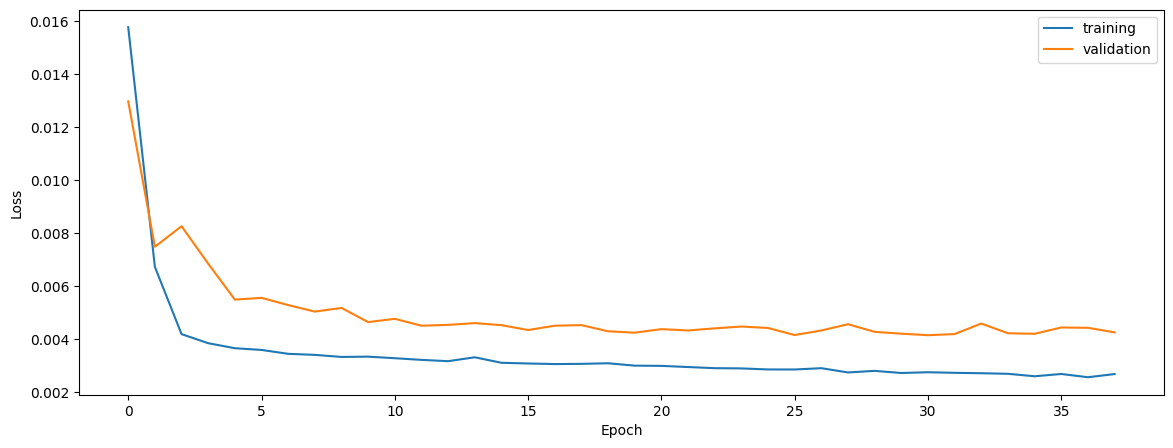

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


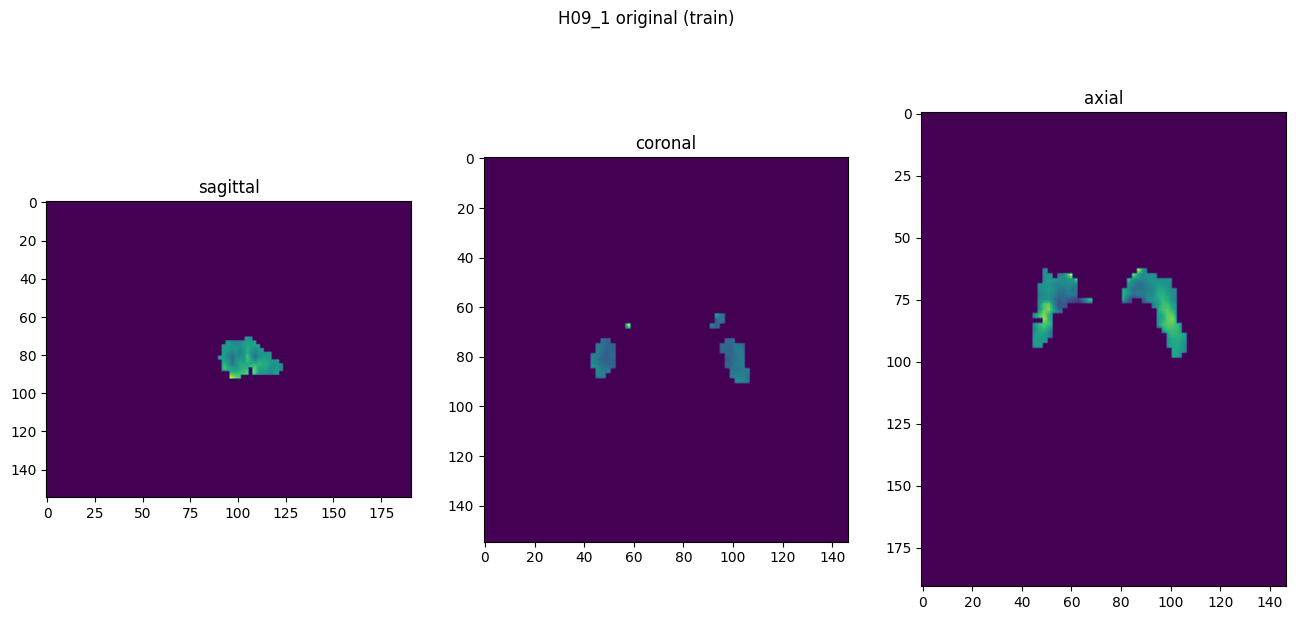

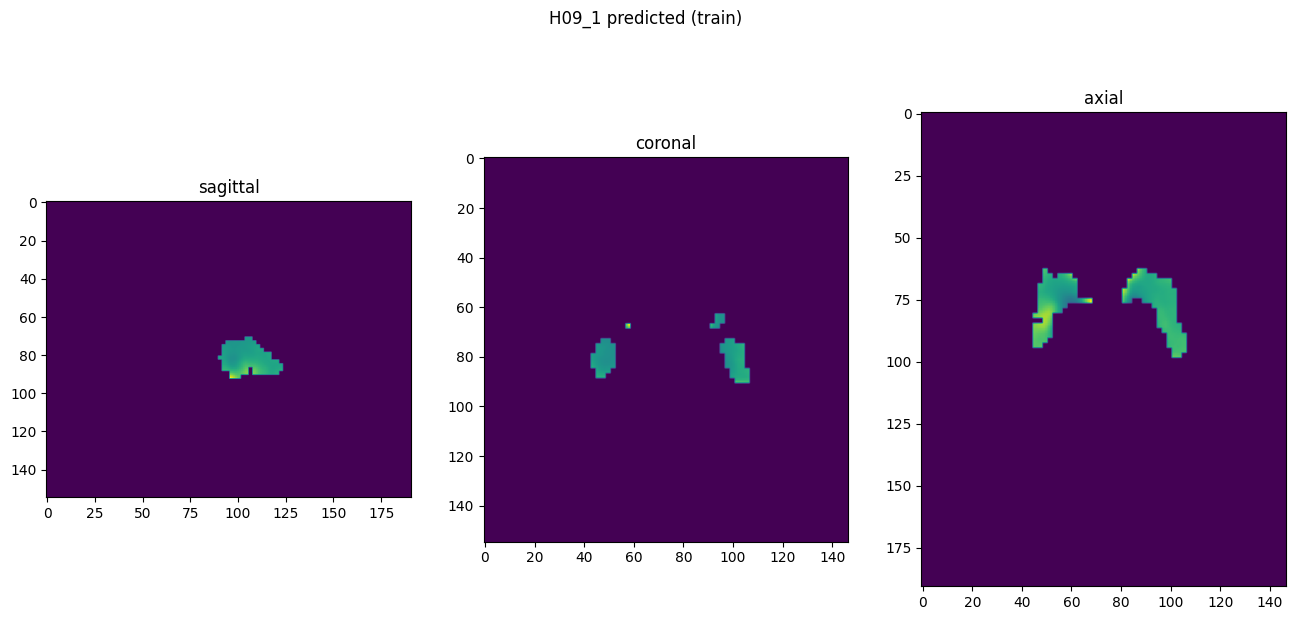

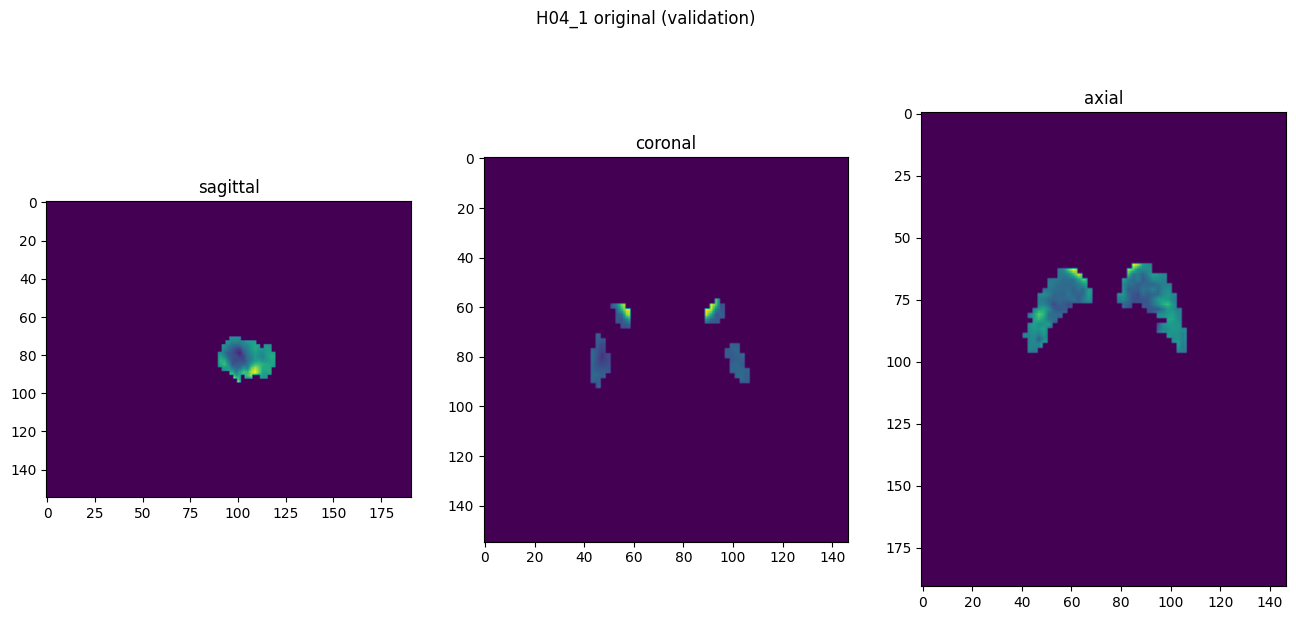

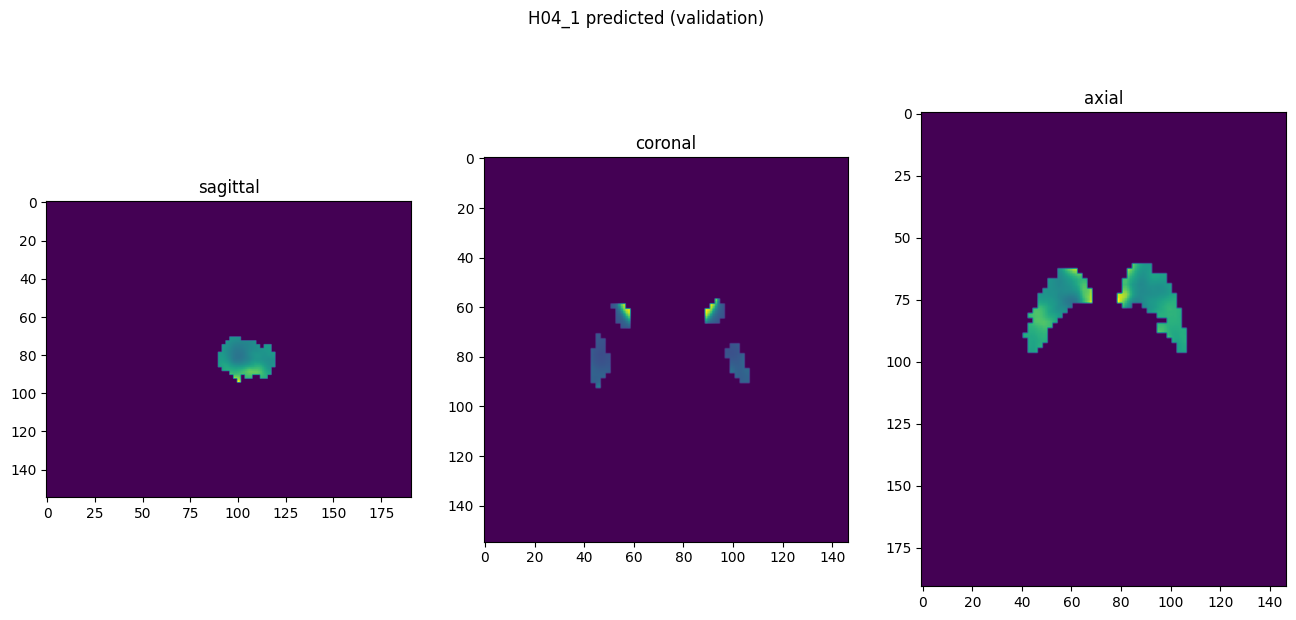

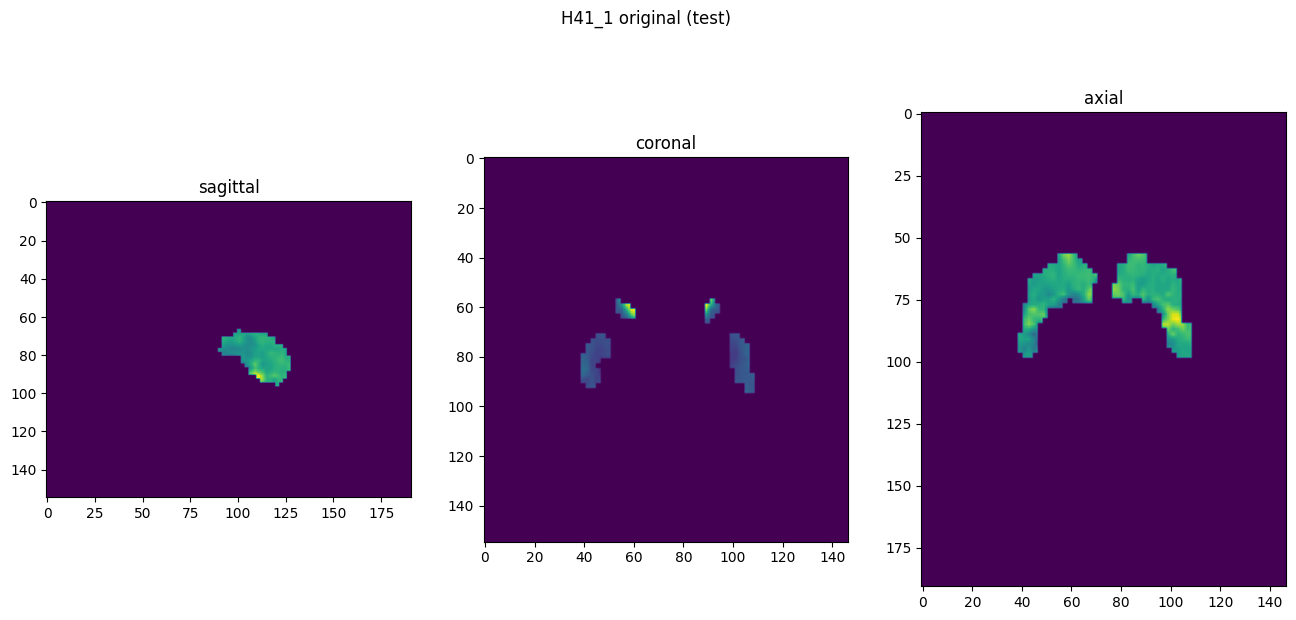

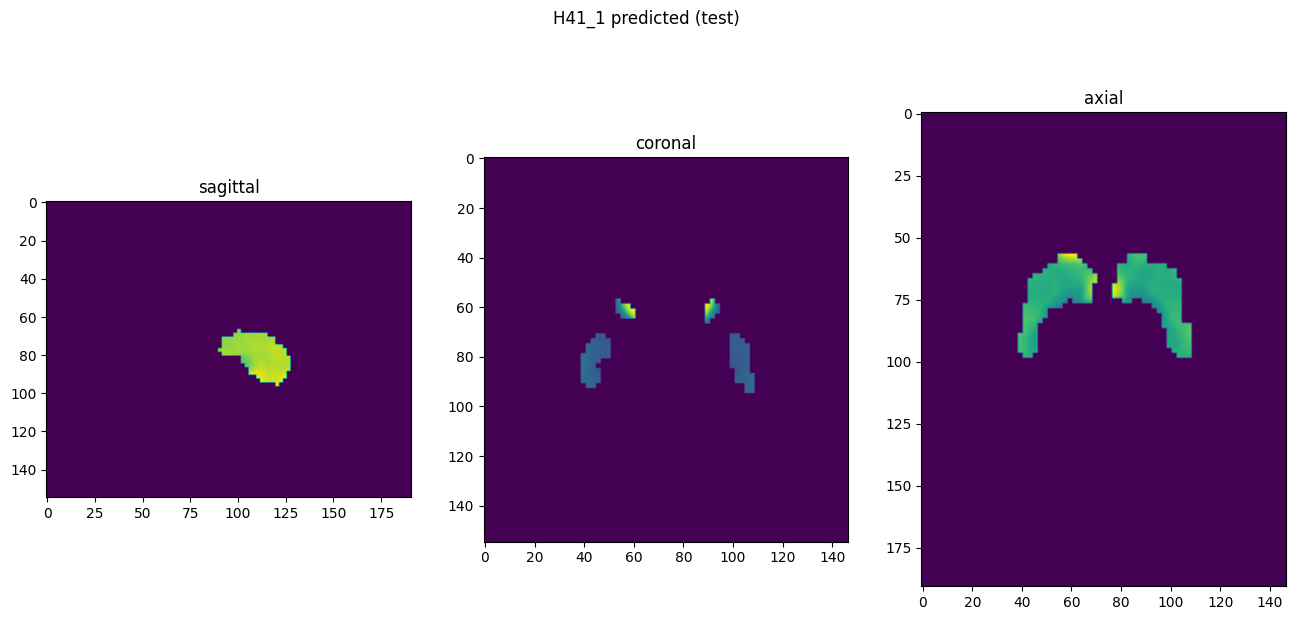

In [10]:
showResults(model, gen, threshold=None, background=False)